In [1]:

# setting logging to print only error messages from Sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from datetime import datetime

#import tensorflow as tf
import os

from sklearn.metrics import mean_squared_error,mean_absolute_error
import math

import warnings
warnings.filterwarnings("ignore")

sns.set_theme(palette="Set2")


def get_mda(y, yhat):
    """Mean Directional Accuracy, as per:
    https://www.wikiwand.com/en/Mean_Directional_Accuracy
    """
    a = np.sign(np.diff(y))
    b = np.sign(np.diff(yhat))
    return np.sum(a == b)/a.shape[0]

In [2]:
!pip install tensorflow


# Importing necessary libaries

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# Read the data

In [4]:
df=pd.read_csv("META  BP DATA.csv")

In [5]:
df.head()

,Date,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
0,01-04-2014,60.459999,62.660000,60.240002,62.619999,59291000.0,3.0,0.100002,3658.399902
1,02-04-2014,63.209999,63.910000,62.209999,62.720001,66277000.0,4.0,-3.229999,3665.989990
2,03-04-2014,62.549999,63.169998,59.130001,59.490002,83859000.0,5.0,-2.740002,3637.580078
3,04-04-2014,59.939999,60.200001,56.320000,56.750000,125214400.0,6.0,0.200001,3539.379883
4,07-04-2014,55.900002,58.000000,55.439999,56.950001,108488000.0,2.0,1.239998,3507.750000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2267 entries, 0 to 2266
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             2205 non-null   object 
 1   Open             2205 non-null   float64
 2   High             2205 non-null   float64
 3   Low              2205 non-null   float64
 4   Close            2205 non-null   float64
 5   Volume           2205 non-null   float64
 6   Day of the week  2205 non-null   float64
 7   Change           2205 non-null   float64
 8   NASDAQ           2205 non-null   float64
dtypes: float64(8), object(1)
memory usage: 159.5+ KB


# Data Preprocessing

In [7]:
df["Date"] = pd.to_datetime(df["Date"])

In [8]:
df.set_index('Date',inplace=True)

In [9]:
df.head()

,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
Date,,,,,,,,
2014-01-04,60.459999,62.660000,60.240002,62.619999,59291000.0,3.0,0.100002,3658.399902
2014-02-04,63.209999,63.910000,62.209999,62.720001,66277000.0,4.0,-3.229999,3665.989990
2014-03-04,62.549999,63.169998,59.130001,59.490002,83859000.0,5.0,-2.740002,3637.580078
2014-04-04,59.939999,60.200001,56.320000,56.750000,125214400.0,6.0,0.200001,3539.379883
2014-07-04,55.900002,58.000000,55.439999,56.950001,108488000.0,2.0,1.239998,3507.750000


# Missing entries


In [10]:
min(df.index)

Timestamp('2014-01-04 00:00:00')

In [11]:
max(df.index)

Timestamp('2022-12-30 00:00:00')

In [12]:
all_datetimes = pd.date_range(min(df.index), max(df.index), freq="D")
all_datetimes

DatetimeIndex(['2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-11',
               '2014-01-12', '2014-01-13',
               ...
               '2022-12-21', '2022-12-22', '2022-12-23', '2022-12-24',
               '2022-12-25', '2022-12-26', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', length=3283, freq='D')

In [13]:
all_datetimes.shape

(3283,)

# Supplying missing values

## Insert missing datetimes

In [14]:
all_datetimes_df = pd.DataFrame(index=all_datetimes)
all_datetimes_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Freq: D
Empty DataFrame

In [15]:
df = pd.merge(all_datetimes_df, df, how="left", left_index=True, right_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             2205 non-null   float64
 1   High             2205 non-null   float64
 2   Low              2205 non-null   float64
 3   Close            2205 non-null   float64
 4   Volume           2205 non-null   float64
 5   Day of the week  2205 non-null   float64
 6   Change           2205 non-null   float64
 7   NASDAQ           2205 non-null   float64
dtypes: float64(8)
memory usage: 230.8 KB


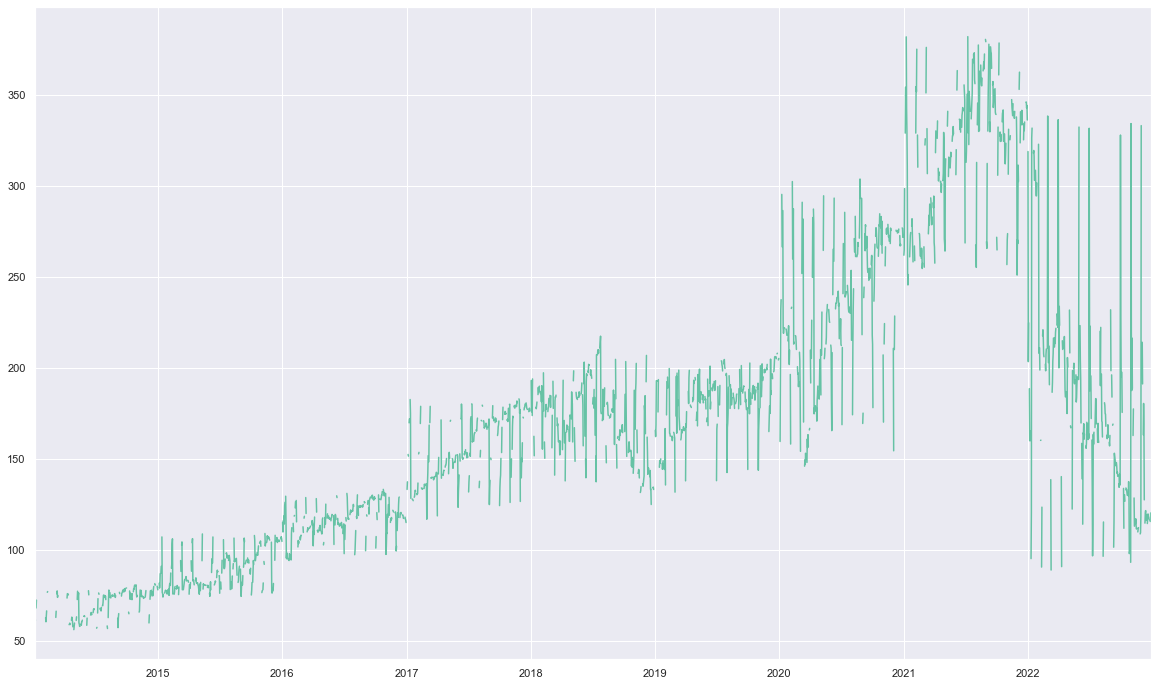

In [16]:
plot = df['Close'].plot(figsize=(20, 12))

In [17]:
df["Close"] = df["Close"].ffill()
df["NASDAQ"]=df["NASDAQ"].ffill()
df["Open"]=df["Open"].ffill()
df["High"]=df["High"].ffill()
df["Low"]=df["Low"].ffill()
df["Volume"]=df["Volume"].ffill()
df["Change"]=df["Change"].ffill()
df.head(12)

,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
2014-01-04,60.459999,62.660000,60.240002,62.619999,59291000.0,3.0,0.100002,3658.399902
2014-01-05,60.430000,62.279999,60.209999,61.150002,82429000.0,5.0,-0.690003,3594.360107
2014-01-06,60.430000,62.279999,60.209999,61.150002,82429000.0,NaN,-0.690003,3594.360107
2014-01-07,67.580002,68.440002,67.389999,68.059998,33243000.0,3.0,-1.610001,3894.330078
2014-01-08,72.220001,73.220001,71.550003,72.360001,43535000.0,6.0,1.150001,3879.669922
2014-01-09,72.220001,73.220001,71.550003,72.360001,43535000.0,NaN,1.150001,3879.669922
2014-01-10,78.779999,78.820000,75.900002,76.550003,55090000.0,4.0,0.529999,3984.739990
2014-01-11,78.779999,78.820000,75.900002,76.550003,55090000.0,NaN,0.529999,3984.739990
2014-01-12,77.260002,77.309998,74.800003,75.099998,31789900.0,2.0,0.360001,4287.810059
2014-01-13,77.260002,77.309998,74.800003,75.099998,31789900.0,NaN,0.360001,4287.810059


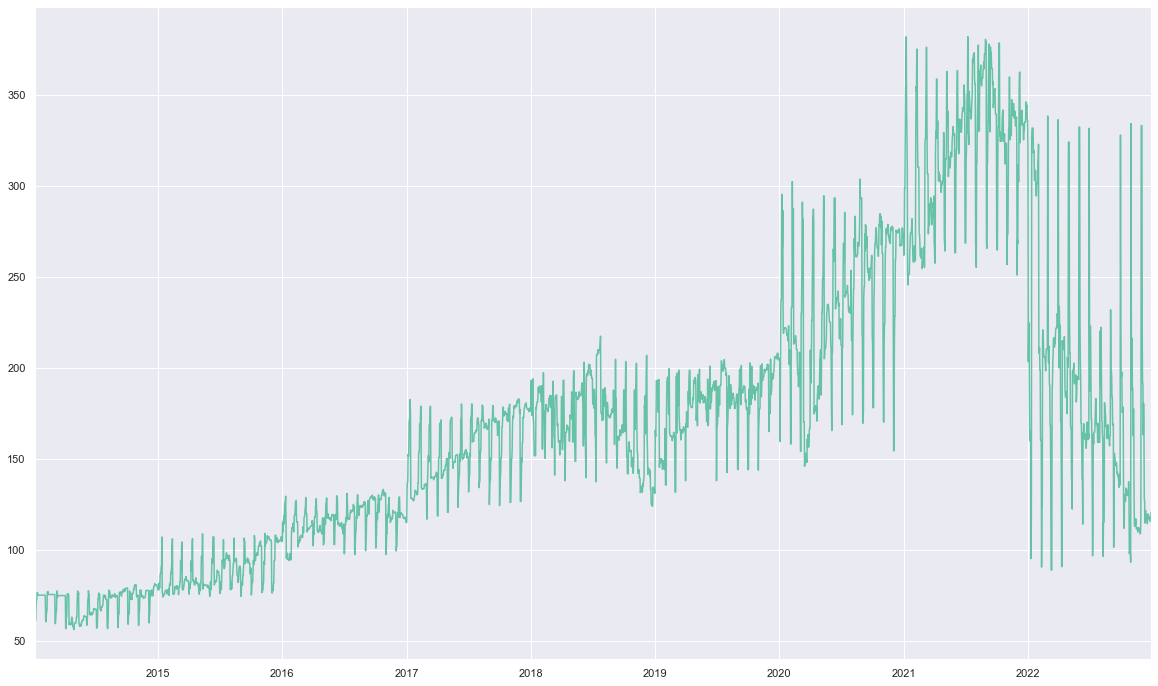

In [18]:
plot = df[ "Close"].plot(figsize=(20, 12))

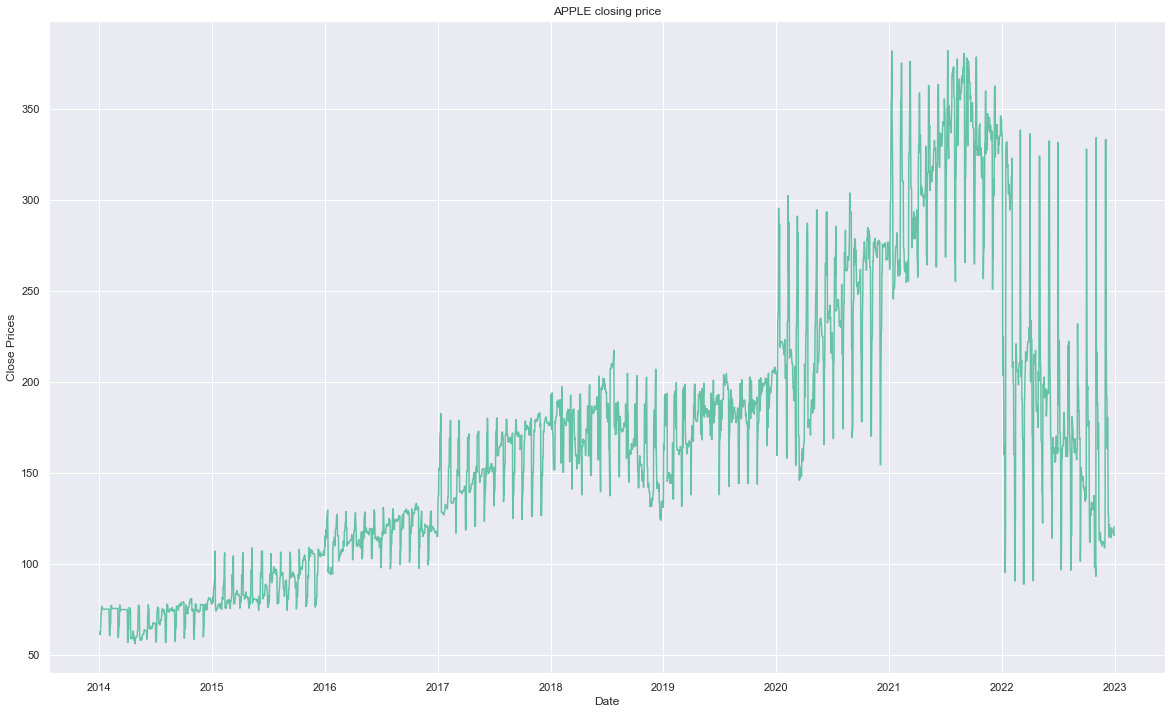

In [19]:
#plot close price
plt.figure(figsize=(20,12))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('APPLE closing price')
plt.show()

In [20]:
df=df["Close"]
df

2014-01-04     62.619999
2014-01-05     61.150002
2014-01-06     61.150002
2014-01-07     68.059998
2014-01-08     72.360001
                 ...    
2022-12-26    118.040001
2022-12-27    116.879997
2022-12-28    115.620003
2022-12-29    120.260002
2022-12-30    120.339996
Name: Close, Length: 3283, dtype: float64

<AxesSubplot:>

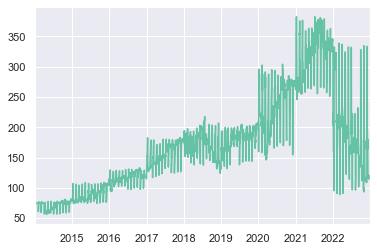

In [21]:
df.plot()

# Build model

In [22]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [23]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(df, WINDOW_SIZE)
X1.shape, y1.shape

((3278, 5, 1), (3278,))

# Train test split

In [24]:
X_train1, y_train1 = X1[:2922], y1[:2922]
X_test1, y_test1 = X1[2922:], y1[2922:]
X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape

((2922, 5, 1), (2922,), (356, 5, 1), (356,))

In [25]:
model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [27]:
model1.fit(X_train1, y_train1, epochs=100, callbacks=[cp1])

Epoch 1/100
91/92 [============================>.] - ETA: 0s - loss: 34465.7070 - root_mean_squared_error: 185.6494

92/92 [==============================] - 2s 3ms/step - loss: 34472.3789 - root_mean_squared_error: 185.6674
Epoch 2/100
85/92 [==========================>...] - ETA: 0s - loss: 34459.0312 - root_mean_squared_error: 185.6314

92/92 [==============================] - 0s 3ms/step - loss: 34265.9375 - root_mean_squared_error: 185.1106
Epoch 3/100
84/92 [==========================>...] - ETA: 0s - loss: 33954.6523 - root_mean_squared_error: 184.2679

92/92 [==============================] - 0s 3ms/step - loss: 33677.3945 - root_mean_squared_error: 183.5140
Epoch 4/100
87/92 [===========================>..] - ETA: 0s - loss: 32844.8789 - root_mean_squared_error: 181.2316

92/92 [==============================] - 0s 2ms/step - loss: 32941.2422 - root_mean_squared_error: 181.4972
Epoch 5/100
91/92 [============================>.] - ETA: 0s - loss: 32118.3730 - root_mean_squared_error: 179.2160

92/92 [==============================] - 0s 2ms/step - loss: 32124.7559 - root_mean_squared_error: 179.2338
Epoch 6/100
71/92 [======================>.......] - ETA: 0s - loss: 31317.4570 - root_mean_squared_error: 176.9674

92/92 [==============================] - 0s 2ms/step - loss: 30899.2832 - root_mean_squared_error: 175.7819
Epoch 7/100
72/92 [======================>.......] - ETA: 0s - loss: 29680.0840 - root_mean_squared_error: 172.2791

92/92 [==============================] - 0s 2ms/step - loss: 29690.9961 - root_mean_squared_error: 172.3108
Epoch 8/100
86/92 [===========================>..] - ETA: 0s - loss: 28574.3945 - root_mean_squared_error: 169.0396

92/92 [==============================] - 0s 2ms/step - loss: 28662.6426 - root_mean_squared_error: 169.3004
Epoch 9/100
88/92 [===========================>..] - ETA: 0s - loss: 27811.6738 - root_mean_squared_error: 166.7683

92/92 [==============================] - 0s 2ms/step - loss: 27928.6191 - root_mean_squared_error: 167.1186
Epoch 10/100
78/92 [========================>.....] - ETA: 0s - loss: 27775.2500 - root_mean_squared_error: 166.6591

92/92 [==============================] - 0s 3ms/step - loss: 27252.2793 - root_mean_squared_error: 165.0826
Epoch 11/100
87/92 [===========================>..] - ETA: 0s - loss: 26576.2500 - root_mean_squared_error: 163.0222

92/92 [==============================] - 0s 3ms/step - loss: 26476.6465 - root_mean_squared_error: 162.7165
Epoch 12/100
87/92 [===========================>..] - ETA: 0s - loss: 25914.9102 - root_mean_squared_error: 160.9811

92/92 [==============================] - 0s 4ms/step - loss: 25866.1211 - root_mean_squared_error: 160.8295
Epoch 13/100
74/92 [=======================>......] - ETA: 0s - loss: 25729.4375 - root_mean_squared_error: 160.4040

92/92 [==============================] - 0s 3ms/step - loss: 25278.0801 - root_mean_squared_error: 158.9908
Epoch 14/100
86/92 [===========================>..] - ETA: 0s - loss: 24646.5840 - root_mean_squared_error: 156.9923

92/92 [==============================] - 0s 2ms/step - loss: 24698.7793 - root_mean_squared_error: 157.1584
Epoch 15/100
91/92 [============================>.] - ETA: 0s - loss: 24102.4414 - root_mean_squared_error: 155.2496

92/92 [==============================] - 0s 4ms/step - loss: 24124.9551 - root_mean_squared_error: 155.3221
Epoch 16/100
91/92 [============================>.] - ETA: 0s - loss: 23508.2617 - root_mean_squared_error: 153.3240

92/92 [==============================] - 0s 4ms/step - loss: 23556.1758 - root_mean_squared_error: 153.4802
Epoch 17/100
89/92 [============================>.] - ETA: 0s - loss: 22864.0820 - root_mean_squared_error: 151.2087

92/92 [==============================] - 0s 4ms/step - loss: 22990.9844 - root_mean_squared_error: 151.6278
Epoch 18/100
87/92 [===========================>..] - ETA: 0s - loss: 22509.9883 - root_mean_squared_error: 150.0333

92/92 [==============================] - 0s 4ms/step - loss: 22430.9902 - root_mean_squared_error: 149.7698
Epoch 19/100
88/92 [===========================>..] - ETA: 0s - loss: 21782.0273 - root_mean_squared_error: 147.5874

92/92 [==============================] - 0s 4ms/step - loss: 21874.6895 - root_mean_squared_error: 147.9009
Epoch 20/100
88/92 [===========================>..] - ETA: 0s - loss: 21451.4395 - root_mean_squared_error: 146.4631

92/92 [==============================] - 0s 5ms/step - loss: 21323.8867 - root_mean_squared_error: 146.0270
Epoch 21/100
91/92 [============================>.] - ETA: 0s - loss: 20765.3125 - root_mean_squared_error: 144.1017

92/92 [==============================] - 0s 4ms/step - loss: 20776.9316 - root_mean_squared_error: 144.1421
Epoch 22/100
84/92 [==========================>...] - ETA: 0s - loss: 20054.9922 - root_mean_squared_error: 141.6156

92/92 [==============================] - 1s 6ms/step - loss: 20233.5254 - root_mean_squared_error: 142.2446
Epoch 23/100
88/92 [===========================>..] - ETA: 0s - loss: 19636.6953 - root_mean_squared_error: 140.1310

92/92 [==============================] - 0s 4ms/step - loss: 19695.1992 - root_mean_squared_error: 140.3396
Epoch 24/100
85/92 [==========================>...] - ETA: 0s - loss: 19276.9492 - root_mean_squared_error: 138.8414

92/92 [==============================] - 0s 4ms/step - loss: 19163.5684 - root_mean_squared_error: 138.4325
Epoch 25/100
85/92 [==========================>...] - ETA: 0s - loss: 18661.2930 - root_mean_squared_error: 136.6063

92/92 [==============================] - 0s 4ms/step - loss: 18637.4121 - root_mean_squared_error: 136.5189
Epoch 26/100
87/92 [===========================>..] - ETA: 0s - loss: 18254.1543 - root_mean_squared_error: 135.1079

92/92 [==============================] - 0s 4ms/step - loss: 18117.1992 - root_mean_squared_error: 134.6001
Epoch 27/100
71/92 [======================>.......] - ETA: 0s - loss: 17616.5957 - root_mean_squared_error: 132.7275

92/92 [==============================] - 0s 3ms/step - loss: 17604.0234 - root_mean_squared_error: 132.6802
Epoch 28/100
88/92 [===========================>..] - ETA: 0s - loss: 17042.5020 - root_mean_squared_error: 130.5469

92/92 [==============================] - 0s 2ms/step - loss: 17099.0098 - root_mean_squared_error: 130.7632
Epoch 29/100
71/92 [======================>.......] - ETA: 0s - loss: 16688.9336 - root_mean_squared_error: 129.1857

92/92 [==============================] - 0s 2ms/step - loss: 16602.6875 - root_mean_squared_error: 128.8514
Epoch 30/100
73/92 [======================>.......] - ETA: 0s - loss: 16132.1094 - root_mean_squared_error: 127.0122

92/92 [==============================] - 0s 2ms/step - loss: 16114.7559 - root_mean_squared_error: 126.9439
Epoch 31/100
84/92 [==========================>...] - ETA: 0s - loss: 15632.5684 - root_mean_squared_error: 125.0303

92/92 [==============================] - 0s 3ms/step - loss: 15636.6807 - root_mean_squared_error: 125.0467
Epoch 32/100
83/92 [==========================>...] - ETA: 0s - loss: 15273.0947 - root_mean_squared_error: 123.5844

92/92 [==============================] - 0s 2ms/step - loss: 15165.8203 - root_mean_squared_error: 123.1496
Epoch 33/100
84/92 [==========================>...] - ETA: 0s - loss: 14814.3857 - root_mean_squared_error: 121.7144

92/92 [==============================] - 0s 2ms/step - loss: 14704.9717 - root_mean_squared_error: 121.2641
Epoch 34/100
80/92 [=========================>....] - ETA: 0s - loss: 14243.8301 - root_mean_squared_error: 119.3475

92/92 [==============================] - 0s 3ms/step - loss: 14254.5117 - root_mean_squared_error: 119.3923
Epoch 35/100
74/92 [=======================>......] - ETA: 0s - loss: 13756.4111 - root_mean_squared_error: 117.2877

92/92 [==============================] - 0s 2ms/step - loss: 13815.7305 - root_mean_squared_error: 117.5403
Epoch 36/100
86/92 [===========================>..] - ETA: 0s - loss: 13527.1699 - root_mean_squared_error: 116.3064

92/92 [==============================] - 0s 5ms/step - loss: 13388.9824 - root_mean_squared_error: 115.7108
Epoch 37/100
88/92 [===========================>..] - ETA: 0s - loss: 12924.3291 - root_mean_squared_error: 113.6852

92/92 [==============================] - 0s 2ms/step - loss: 12972.0352 - root_mean_squared_error: 113.8948
Epoch 38/100
86/92 [===========================>..] - ETA: 0s - loss: 12665.2705 - root_mean_squared_error: 112.5401

92/92 [==============================] - 0s 3ms/step - loss: 12565.5020 - root_mean_squared_error: 112.0959
Epoch 39/100
81/92 [=========================>....] - ETA: 0s - loss: 12164.5400 - root_mean_squared_error: 110.2930

92/92 [==============================] - 0s 4ms/step - loss: 12162.3418 - root_mean_squared_error: 110.2830
Epoch 40/100
70/92 [=====================>........] - ETA: 0s - loss: 11941.6777 - root_mean_squared_error: 109.2780

92/92 [==============================] - 0s 3ms/step - loss: 11758.6348 - root_mean_squared_error: 108.4372
Epoch 41/100
91/92 [============================>.] - ETA: 0s - loss: 11373.7344 - root_mean_squared_error: 106.6477

92/92 [==============================] - 0s 3ms/step - loss: 11365.6641 - root_mean_squared_error: 106.6099
Epoch 42/100
84/92 [==========================>...] - ETA: 0s - loss: 11120.7285 - root_mean_squared_error: 105.4549

92/92 [==============================] - 0s 5ms/step - loss: 10965.1895 - root_mean_squared_error: 104.7148
Epoch 43/100
90/92 [============================>.] - ETA: 0s - loss: 10531.9355 - root_mean_squared_error: 102.6252

92/92 [==============================] - 0s 5ms/step - loss: 10570.4492 - root_mean_squared_error: 102.8127
Epoch 44/100
91/92 [============================>.] - ETA: 0s - loss: 10206.8936 - root_mean_squared_error: 101.0292

92/92 [==============================] - 0s 4ms/step - loss: 10192.8926 - root_mean_squared_error: 100.9599
Epoch 45/100
92/92 [==============================] - ETA: 0s - loss: 9826.0498 - root_mean_squared_error: 99.1264

92/92 [==============================] - 0s 5ms/step - loss: 9826.0498 - root_mean_squared_error: 99.1264
Epoch 46/100
86/92 [===========================>..] - ETA: 0s - loss: 9528.9258 - root_mean_squared_error: 97.6162

92/92 [==============================] - 0s 4ms/step - loss: 9468.2842 - root_mean_squared_error: 97.3051
Epoch 47/100
89/92 [============================>.] - ETA: 0s - loss: 9053.4658 - root_mean_squared_error: 95.1497

92/92 [==============================] - 0s 4ms/step - loss: 9119.1494 - root_mean_squared_error: 95.4942
Epoch 48/100
87/92 [===========================>..] - ETA: 0s - loss: 8742.0410 - root_mean_squared_error: 93.4989

92/92 [==============================] - 0s 5ms/step - loss: 8780.5850 - root_mean_squared_error: 93.7048
Epoch 49/100
85/92 [==========================>...] - ETA: 0s - loss: 8529.3076 - root_mean_squared_error: 92.3542

92/92 [==============================] - 0s 5ms/step - loss: 8453.8232 - root_mean_squared_error: 91.9447
Epoch 50/100
79/92 [========================>.....] - ETA: 0s - loss: 8079.6367 - root_mean_squared_error: 89.8868

92/92 [==============================] - 0s 5ms/step - loss: 8135.8843 - root_mean_squared_error: 90.1991
Epoch 51/100
90/92 [============================>.] - ETA: 0s - loss: 7782.5908 - root_mean_squared_error: 88.2190

92/92 [==============================] - 0s 4ms/step - loss: 7828.9263 - root_mean_squared_error: 88.4812
Epoch 52/100
90/92 [============================>.] - ETA: 0s - loss: 7453.7515 - root_mean_squared_error: 86.3351

92/92 [==============================] - 0s 5ms/step - loss: 7531.9331 - root_mean_squared_error: 86.7867
Epoch 53/100
83/92 [==========================>...] - ETA: 0s - loss: 7250.9224 - root_mean_squared_error: 85.1524

92/92 [==============================] - 0s 4ms/step - loss: 7242.9443 - root_mean_squared_error: 85.1055
Epoch 54/100
83/92 [==========================>...] - ETA: 0s - loss: 6972.9609 - root_mean_squared_error: 83.5043

92/92 [==============================] - 0s 4ms/step - loss: 6962.2544 - root_mean_squared_error: 83.4401
Epoch 55/100
91/92 [============================>.] - ETA: 0s - loss: 6705.4600 - root_mean_squared_error: 81.8869

92/92 [==============================] - 0s 5ms/step - loss: 6691.4663 - root_mean_squared_error: 81.8014
Epoch 56/100
86/92 [===========================>..] - ETA: 0s - loss: 6438.7305 - root_mean_squared_error: 80.2417

92/92 [==============================] - 0s 5ms/step - loss: 6429.6104 - root_mean_squared_error: 80.1849
Epoch 57/100
91/92 [============================>.] - ETA: 0s - loss: 6186.4038 - root_mean_squared_error: 78.6537

92/92 [==============================] - 0s 5ms/step - loss: 6176.5293 - root_mean_squared_error: 78.5909
Epoch 58/100
89/92 [============================>.] - ETA: 0s - loss: 5992.8604 - root_mean_squared_error: 77.4136

92/92 [==============================] - 0s 5ms/step - loss: 5931.4209 - root_mean_squared_error: 77.0157
Epoch 59/100
87/92 [===========================>..] - ETA: 0s - loss: 5674.6353 - root_mean_squared_error: 75.3302

92/92 [==============================] - 0s 4ms/step - loss: 5677.4824 - root_mean_squared_error: 75.3491
Epoch 60/100
85/92 [==========================>...] - ETA: 0s - loss: 5453.3901 - root_mean_squared_error: 73.8471

92/92 [==============================] - 1s 6ms/step - loss: 5432.6094 - root_mean_squared_error: 73.7062
Epoch 61/100
83/92 [==========================>...] - ETA: 0s - loss: 5279.5259 - root_mean_squared_error: 72.6603

92/92 [==============================] - 0s 5ms/step - loss: 5207.1812 - root_mean_squared_error: 72.1608
Epoch 62/100
87/92 [===========================>..] - ETA: 0s - loss: 4965.1724 - root_mean_squared_error: 70.4640

92/92 [==============================] - 0s 5ms/step - loss: 4993.0312 - root_mean_squared_error: 70.6614
Epoch 63/100
90/92 [============================>.] - ETA: 0s - loss: 4780.9722 - root_mean_squared_error: 69.1446

92/92 [==============================] - 0s 5ms/step - loss: 4790.0166 - root_mean_squared_error: 69.2099
Epoch 64/100
86/92 [===========================>..] - ETA: 0s - loss: 4689.4468 - root_mean_squared_error: 68.4795

92/92 [==============================] - 0s 4ms/step - loss: 4595.6240 - root_mean_squared_error: 67.7910
Epoch 65/100
92/92 [==============================] - ETA: 0s - loss: 4410.4946 - root_mean_squared_error: 66.4116

92/92 [==============================] - 0s 5ms/step - loss: 4410.4946 - root_mean_squared_error: 66.4116
Epoch 66/100
92/92 [==============================] - ETA: 0s - loss: 4233.4580 - root_mean_squared_error: 65.0650

92/92 [==============================] - 0s 5ms/step - loss: 4233.4580 - root_mean_squared_error: 65.0650
Epoch 67/100
80/92 [=========================>....] - ETA: 0s - loss: 4019.4421 - root_mean_squared_error: 63.3991

92/92 [==============================] - 0s 4ms/step - loss: 4064.2080 - root_mean_squared_error: 63.7511
Epoch 68/100
86/92 [===========================>..] - ETA: 0s - loss: 3987.9783 - root_mean_squared_error: 63.1504

92/92 [==============================] - 0s 5ms/step - loss: 3901.2964 - root_mean_squared_error: 62.4604
Epoch 69/100
86/92 [===========================>..] - ETA: 0s - loss: 3732.3208 - root_mean_squared_error: 61.0927

92/92 [==============================] - 0s 4ms/step - loss: 3747.3938 - root_mean_squared_error: 61.2160
Epoch 70/100
87/92 [===========================>..] - ETA: 0s - loss: 3596.9819 - root_mean_squared_error: 59.9748

92/92 [==============================] - 0s 4ms/step - loss: 3600.1499 - root_mean_squared_error: 60.0012
Epoch 71/100
79/92 [========================>.....] - ETA: 0s - loss: 3453.7144 - root_mean_squared_error: 58.7683

92/92 [==============================] - 0s 4ms/step - loss: 3457.4580 - root_mean_squared_error: 58.8002
Epoch 72/100
85/92 [==========================>...] - ETA: 0s - loss: 3405.3625 - root_mean_squared_error: 58.3555

92/92 [==============================] - 0s 5ms/step - loss: 3320.1416 - root_mean_squared_error: 57.6207
Epoch 73/100
91/92 [============================>.] - ETA: 0s - loss: 3189.3511 - root_mean_squared_error: 56.4743

92/92 [==============================] - 0s 5ms/step - loss: 3188.6250 - root_mean_squared_error: 56.4679
Epoch 74/100
90/92 [============================>.] - ETA: 0s - loss: 3024.9612 - root_mean_squared_error: 54.9996

92/92 [==============================] - 0s 5ms/step - loss: 3061.9470 - root_mean_squared_error: 55.3349
Epoch 75/100
87/92 [===========================>..] - ETA: 0s - loss: 2911.8816 - root_mean_squared_error: 53.9619

92/92 [==============================] - 0s 5ms/step - loss: 2939.2720 - root_mean_squared_error: 54.2151
Epoch 76/100
91/92 [============================>.] - ETA: 0s - loss: 2813.8044 - root_mean_squared_error: 53.0453

92/92 [==============================] - 0s 5ms/step - loss: 2819.5671 - root_mean_squared_error: 53.0996
Epoch 77/100
87/92 [===========================>..] - ETA: 0s - loss: 2739.4114 - root_mean_squared_error: 52.3394

92/92 [==============================] - 0s 4ms/step - loss: 2703.4719 - root_mean_squared_error: 51.9949
Epoch 78/100
85/92 [==========================>...] - ETA: 0s - loss: 2595.2185 - root_mean_squared_error: 50.9433

92/92 [==============================] - 0s 5ms/step - loss: 2591.4763 - root_mean_squared_error: 50.9065
Epoch 79/100
87/92 [===========================>..] - ETA: 0s - loss: 2525.6675 - root_mean_squared_error: 50.2560

92/92 [==============================] - 0s 5ms/step - loss: 2482.3945 - root_mean_squared_error: 49.8236
Epoch 80/100
82/92 [=========================>....] - ETA: 0s - loss: 2394.6514 - root_mean_squared_error: 48.9352

92/92 [==============================] - 0s 5ms/step - loss: 2375.4661 - root_mean_squared_error: 48.7388
Epoch 81/100
89/92 [============================>.] - ETA: 0s - loss: 2281.6360 - root_mean_squared_error: 47.7665

92/92 [==============================] - 0s 5ms/step - loss: 2272.4414 - root_mean_squared_error: 47.6701
Epoch 82/100
89/92 [============================>.] - ETA: 0s - loss: 2167.7302 - root_mean_squared_error: 46.5589

92/92 [==============================] - 0s 5ms/step - loss: 2172.3206 - root_mean_squared_error: 46.6082
Epoch 83/100
88/92 [===========================>..] - ETA: 0s - loss: 2068.4421 - root_mean_squared_error: 45.4801

92/92 [==============================] - 0s 4ms/step - loss: 2075.1094 - root_mean_squared_error: 45.5534
Epoch 84/100
79/92 [========================>.....] - ETA: 0s - loss: 1997.1821 - root_mean_squared_error: 44.6898

92/92 [==============================] - 0s 5ms/step - loss: 1980.3411 - root_mean_squared_error: 44.5010
Epoch 85/100
87/92 [===========================>..] - ETA: 0s - loss: 1898.8429 - root_mean_squared_error: 43.5757

92/92 [==============================] - 0s 5ms/step - loss: 1889.2440 - root_mean_squared_error: 43.4654
Epoch 86/100
82/92 [=========================>....] - ETA: 0s - loss: 1814.2827 - root_mean_squared_error: 42.5944

92/92 [==============================] - 0s 4ms/step - loss: 1800.6826 - root_mean_squared_error: 42.4345
Epoch 87/100
90/92 [============================>.] - ETA: 0s - loss: 1716.2203 - root_mean_squared_error: 41.4273

92/92 [==============================] - 0s 5ms/step - loss: 1715.1584 - root_mean_squared_error: 41.4145
Epoch 88/100
92/92 [==============================] - ETA: 0s - loss: 1630.8693 - root_mean_squared_error: 40.3840

92/92 [==============================] - 0s 4ms/step - loss: 1630.8693 - root_mean_squared_error: 40.3840
Epoch 89/100
89/92 [============================>.] - ETA: 0s - loss: 1568.6267 - root_mean_squared_error: 39.6059

92/92 [==============================] - 0s 5ms/step - loss: 1551.3700 - root_mean_squared_error: 39.3874
Epoch 90/100
90/92 [============================>.] - ETA: 0s - loss: 1481.8364 - root_mean_squared_error: 38.4946

92/92 [==============================] - 0s 4ms/step - loss: 1474.9042 - root_mean_squared_error: 38.4045
Epoch 91/100
87/92 [===========================>..] - ETA: 0s - loss: 1369.9561 - root_mean_squared_error: 37.0129

92/92 [==============================] - 0s 4ms/step - loss: 1400.5265 - root_mean_squared_error: 37.4236
Epoch 92/100
89/92 [============================>.] - ETA: 0s - loss: 1291.6224 - root_mean_squared_error: 35.9391

92/92 [==============================] - 0s 4ms/step - loss: 1329.5271 - root_mean_squared_error: 36.4627
Epoch 93/100
91/92 [============================>.] - ETA: 0s - loss: 1262.6940 - root_mean_squared_error: 35.5344

92/92 [==============================] - 0s 4ms/step - loss: 1262.3508 - root_mean_squared_error: 35.5296
Epoch 94/100
80/92 [=========================>....] - ETA: 0s - loss: 1206.8207 - root_mean_squared_error: 34.7393

92/92 [==============================] - 0s 4ms/step - loss: 1196.6433 - root_mean_squared_error: 34.5925
Epoch 95/100
82/92 [=========================>....] - ETA: 0s - loss: 1129.4087 - root_mean_squared_error: 33.6067

92/92 [==============================] - 0s 4ms/step - loss: 1134.5151 - root_mean_squared_error: 33.6826
Epoch 96/100
90/92 [============================>.] - ETA: 0s - loss: 1068.9476 - root_mean_squared_error: 32.6948

92/92 [==============================] - 0s 4ms/step - loss: 1075.2870 - root_mean_squared_error: 32.7916
Epoch 97/100
82/92 [=========================>....] - ETA: 0s - loss: 1017.2334 - root_mean_squared_error: 31.8941

92/92 [==============================] - 0s 4ms/step - loss: 1018.3763 - root_mean_squared_error: 31.9120
Epoch 98/100
90/92 [============================>.] - ETA: 0s - loss: 963.6356 - root_mean_squared_error: 31.0425

92/92 [==============================] - 0s 4ms/step - loss: 964.4340 - root_mean_squared_error: 31.0553
Epoch 99/100
80/92 [=========================>....] - ETA: 0s - loss: 919.9647 - root_mean_squared_error: 30.3309

92/92 [==============================] - 0s 4ms/step - loss: 913.3376 - root_mean_squared_error: 30.2215
Epoch 100/100
87/92 [===========================>..] - ETA: 0s - loss: 856.5697 - root_mean_squared_error: 29.2672

92/92 [==============================] - 0s 5ms/step - loss: 865.3992 - root_mean_squared_error: 29.4177


In [28]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

92/92 [==============================] - 1s 2ms/step


,Train Predictions,Actuals
0,73.296555,72.360001
1,73.544334,76.550003
2,77.241089,76.550003
3,77.567696,75.099998
4,76.364388,75.099998
...,...,...
2917,231.404800,224.850006
2918,235.706955,224.850006
2919,230.487503,188.639999
2920,197.774445,160.029999


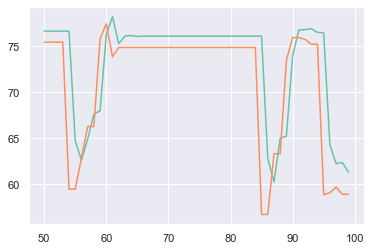

In [30]:

plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [31]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

12/12 [==============================] - 0s 2ms/step


,Test Predictions,Actuals
0,167.441330,165.360001
1,169.627426,165.360001
2,167.583572,95.199997
3,115.233482,120.440002
4,124.052231,326.480011
...,...,...
351,118.915039,118.040001
352,118.955269,116.879997
353,117.888611,115.620003
354,116.735954,120.260002


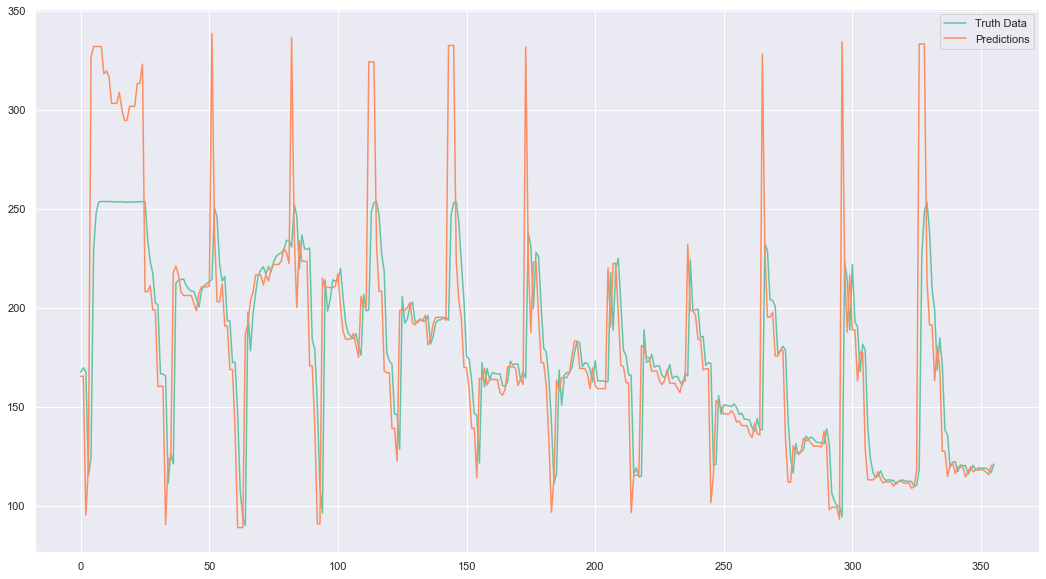

In [33]:
plt.figure(figsize=(18,10))
plt.plot(test_results['Test Predictions'][:356])
plt.plot(test_results['Actuals'][:356])

plt.legend(['Truth Data', 'Predictions'])

# Evaluating forecast results

In [68]:
score = np.sqrt(mean_squared_error(test_results['Test Predictions'], test_results['Actuals']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 36.91


In [69]:
# report performance
mse = mean_squared_error(test_predictions, y_test1)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_predictions, y_test1)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_predictions, y_test1))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(y_test1 - test_predictions)/np.abs(test_predictions))
print('MAPE: '+str(mape))

MSE: 1362.364899478907
MAE: 18.122013309012083
RMSE: 36.91022757284093
MAPE: 0.10891026744457773


In [70]:
get_mda(y_test1,test_predictions)

0.3352112676056338